In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import matplotlib.lines as mlines
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Import the project utils
sys.path.insert(0, '../utilities/')
from sequence_logo import *
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
mwc.set_plotting_style()

# Set color scheme
colors=sns.color_palette('RdPu_r', 6)[1:]
colors_alt=sns.color_palette('Blues')
colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b', '#905426'])

sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [39]:
# Import list of mutant operators

mut_ops = pd.read_csv('../../notes/Onew_mutants_list.csv')

# Import measured binding energies

measured = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)

# Make dictionary of mutant operators and measured binding energies
energies_list = []
mut_list = []
seq_list = []
for name in mut_ops.ID:
    for op in measured.operator:
        if name.lstrip('mut') in op:
            energies_list.append(measured.energy_kBT[measured.operator==op].values[0])
            mut_list.append(name)
            seq_list.append(mut_ops.seq[mut_ops.ID==name].values[0])
            
# Make new dataframe storing these values
df = pd.DataFrame({'ID' : mut_list, 'sequence' : seq_list, 'measured_energy' : energies_list})
df.head()

,ID,measured_energy,sequence
0,mut005,-12.242242,AATTGTGAGCGGAGAACAATT
1,mut007,-15.297297,AATTGTGAGCGCATAACAATT
2,mut008,-14.988989,AATTGTGAGCGGATCACAATT
3,mut009,-12.501502,AATTGTGAGCGGAAAACAATT
4,mut010,-11.296296,AATTGCGAGCGGATAACAATT


In [40]:
# Input useful functions for working with energy matrices

def least_squares(alpha, op, dep_var, indep_var):
    '''
    Computes the log posterior for a single set of parameters.
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    
    # compute the theoretical fold-change
    e_meas_theory = linear_scaling(alpha, indep_var, op)
    
    # return the log posterior
    return np.sum((dep_var - e_meas_theory)**2)

def scaling_factor_least_squares(matrix, dataframe, op, alpha_list):
    x = np.array([sortseq.binding_energy(seq, matrix, 0) for seq in dataframe.sequence])
    y = dataframe.measured_energy.values

    output = []
    for a in alpha_list:
        output.append(least_squares(a, op, y, x))
    
    alpha = alpha_list[np.where(output == min(output))][0]
    
    return alpha, output

def linear_scaling(alpha, e_pred, e_wt):
    return alpha * e_pred + e_wt

13.1313131313
10.6710671067
11.7311731173
12.8512851285
10.6510651065
11.4911491149


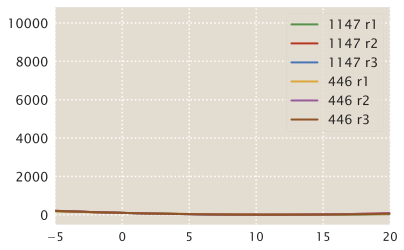

In [41]:
# Import energy matrices (no multiplier)

# Create lists of RBS and operator names to be used for importing
RBS_name = ['1147', '446']
repressor_dict = dict(zip(RBS_name, [30, 62]))
op = 'O1'
wt = 'AATTGTGAGCGGATAACAATT'
replicate_num = ['r1', 'r2', 'r3']

# Make a dictionary to store matrix files and label by operator and RBS
O1_matrix_dict = {}

for RBS in RBS_name:
    inner_dict = {}
    for rep in replicate_num:
        # Load matrix
        array = np.loadtxt('../../data/models/replicates/%s_%s_%s_energy_matrix' % (op, RBS, rep),\
                                     skiprows=1, usecols=(-4, -3, -2, -1))
        array = np.array(sortseq.fix_wt(array, wt))
        np.savetxt('%s_%s_%s_energy_matrix_au.csv' % (op, RBS, rep), array, delimiter=',')
        # Find theoretical scaling factor
        alpha_list = np.linspace(-100, 100, 10000)
        scaling_factor, _ = scaling_factor_least_squares(array, df[0:9], -15.3, alpha_list)
        print(scaling_factor)
        plt.plot(alpha_list, _, label=('%s %s' % (RBS, rep)))
        plt.xlim(-5, 20)
        scaled_array = array * scaling_factor
        # Add scaled array to dict
        inner_dict[rep] = scaled_array
    O1_matrix_dict[RBS] = inner_dict
plt.legend()

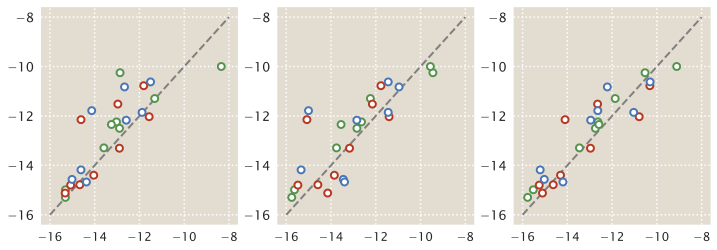

In [42]:
replicate_num = ['r1', 'r2', 'r3']

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

for i, a in enumerate(ax):
    all_preds = [sortseq.binding_energy(seq, O1_matrix_dict['446'][replicate_num[i]], -15.3) for seq in df.sequence]
    a.plot([-16, -8], [-16, -8], ls='--', color='gray')
    predictions_1bp = []
    measurements_1bp = []
    predictions_2bp = []
    measurements_2bp = []
    predictions_3bp = []
    measurements_3bp = []
    for j, name in enumerate(df.ID.unique()):
        if name.startswith('mut0'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[0], zorder=9)
            predictions_1bp.append(pred)
            measurements_1bp.append(meas)
        if name.startswith('mut1'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[1], zorder=9)
            predictions_2bp.append(pred)
            measurements_2bp.append(meas)
        if name.startswith('mut2'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[2], zorder=9)
            predictions_3bp.append(pred)
            measurements_3bp.append(meas)

11.5111511151
-2.1102110211
11.0311031103
12.7112711271
6.81068106811
4.8104810481


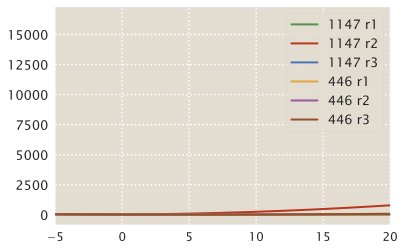

In [43]:
# Create lists of RBS and operator names to be used for importing
RBS_name = ['1147', '446']
repressor_dict = dict(zip(RBS_name, [30, 62]))
op = 'O2'
wt = 'AAATGTGAGCGAGTAACAACC'
replicate_num = ['r1', 'r2', 'r3']

# Make a dictionary to store matrix files and label by operator and RBS
O2_matrix_dict = {}

for RBS in RBS_name:
    inner_dict = {}
    for rep in replicate_num:
        # Load matrix
        array = np.loadtxt('../../data/models/replicates/%s_%s_%s_energy_matrix' % (op, RBS, rep),\
                                     skiprows=1, usecols=(-4, -3, -2, -1))
        array = np.array(sortseq.fix_wt(array, wt))
        np.savetxt('%s_%s_%s_energy_matrix_au.csv' % (op, RBS, rep), array, delimiter=',')
        # Find theoretical scaling factor
        alpha_list = np.linspace(-100, 100, 10000)
        scaling_factor, _ = scaling_factor_least_squares(array, df[0:8], -13.9, alpha_list)
        print(scaling_factor)
        plt.plot(alpha_list, _, label=('%s %s' % (RBS, rep)))
        plt.xlim(-5, 20)
        scaled_array = array * scaling_factor
        # Add scaled array to dict
        inner_dict[rep] = scaled_array
    O2_matrix_dict[RBS] = inner_dict
    
plt.legend()

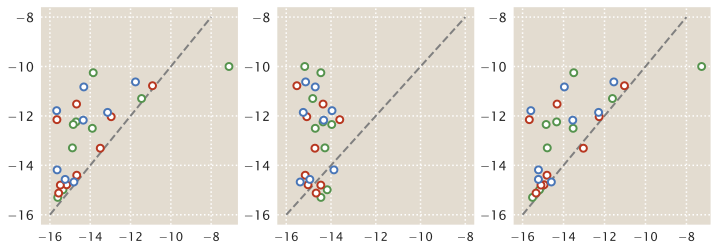

In [44]:
replicate_num = ['r1', 'r2', 'r3']

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

for i, a in enumerate(ax):
    all_preds = [sortseq.binding_energy(seq, O2_matrix_dict['1147'][replicate_num[i]], -15.3) for seq in df.sequence]
    a.plot([-16, -8], [-16, -8], ls='--', color='gray')
    predictions_1bp = []
    measurements_1bp = []
    predictions_2bp = []
    measurements_2bp = []
    predictions_3bp = []
    measurements_3bp = []
    for j, name in enumerate(df.ID.unique()):
        if name.startswith('mut0'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[0], zorder=9)
            predictions_1bp.append(pred)
            measurements_1bp.append(meas)
        if name.startswith('mut1'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[1], zorder=9)
            predictions_2bp.append(pred)
            measurements_2bp.append(meas)
        if name.startswith('mut2'):
            pred = all_preds[j]
            meas = df.measured_energy[df.ID==name].values[0]
            a.plot(pred, meas, 'o', markeredgewidth=2, markerfacecolor='white',\
                       markeredgecolor=colors_qual[2], zorder=9)
            predictions_3bp.append(pred)
            measurements_3bp.append(meas)

# Sequence logo comparison

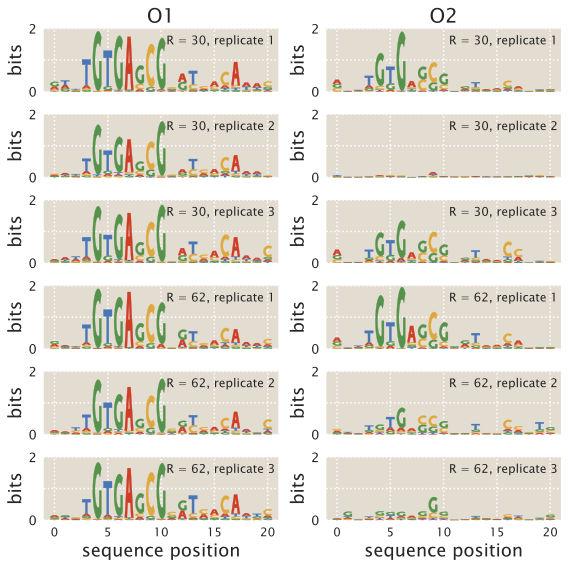

In [45]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(8, 8))

# Plot all for R = 30
for i, rep in enumerate(replicate_num):
    seq_logo(O1_matrix_dict['1147'][rep], ax=ax[i][0], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    seq_logo(O2_matrix_dict['1147'][rep], ax=ax[i][1], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    ax[i][0].set_xlim(0, 22)
    ax[i][0].set_ylim(0, 2)
    ax[i][0].set_yticks([0, 1, 2])
    ax[i][0].set_ylabel('bits')
    ax[i][0].set_yticklabels(['0', '', '2'])
    ax[i][0].set_xticks([1, 6, 11, 16, 21])
    ax[i][0].set_xticklabels(['', '', '', '', ''])
    ax[i][0].text(11.5, 1.5, 'R = 30, replicate %i' % (i + 1), fontsize=12)
    ax[i][1].set_xlim(0, 22)
    ax[i][1].set_ylim(0, 2)
    ax[i][1].set_yticks([0, 1, 2])
    ax[i][1].set_ylabel('bits')
    ax[i][1].set_yticklabels(['0', '', '2'])
    ax[i][1].set_xticks([1, 6, 11, 16, 21])
    ax[i][1].set_xticklabels(['', '', '', '', ''])
    ax[i][1].text(11.5, 1.5, 'R = 30, replicate %i' % (i + 1), fontsize=12)

# Plot all for R = 62
for i, rep in enumerate(replicate_num):
    seq_logo(O1_matrix_dict['446'][rep], ax=ax[i+3][0], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    seq_logo(O2_matrix_dict['446'][rep], ax=ax[i+3][1], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    ax[i+3][0].set_xlim(0, 22)
    ax[i+3][0].set_ylim(0, 2)
    ax[i+3][0].set_yticks([0, 1, 2])
    ax[i+3][0].set_ylabel('bits')
    ax[i+3][0].set_yticklabels(['0', '', '2'])
    ax[i+3][0].set_xticks([1, 6, 11, 16, 21])
    ax[i+3][0].set_xticklabels(['', '', '', '', ''])
    ax[i+3][0].text(11.5, 1.5, 'R = 62, replicate %i' % (i + 1), fontsize=12)
    ax[i+3][1].set_xlim(0, 22)
    ax[i+3][1].set_ylim(0, 2)
    ax[i+3][1].set_yticks([0, 1, 2])
    ax[i+3][1].set_ylabel('bits')
    ax[i+3][1].set_yticklabels(['0', '', '2'])
    ax[i+3][1].set_xticks([1, 6, 11, 16, 21])
    ax[i+3][1].set_xticklabels(['', '', '', '', ''])
    ax[i+3][1].text(11.5, 1.5, 'R = 62, replicate %i' % (i + 1), fontsize=12)
    
ax[5][0].set_xticklabels([0, 5, 10, 15, 20])
ax[5][0].set_xlabel('sequence position')
ax[0][0].set_title(r'O1')
ax[5][1].set_xticklabels([0, 5, 10, 15, 20])
ax[5][1].set_xlabel('sequence position')
ax[0][1].set_title(r'O2')

plt.tight_layout()
#plt.savefig('replicate_logos.pdf', bbox_inches='tight')

# Comparing corellation coefficient

Another way to perform this analysis would be to compute the Pearson's correlation coefficient between the values in energy matrices. If they are highly linear then they can be considered similar. 

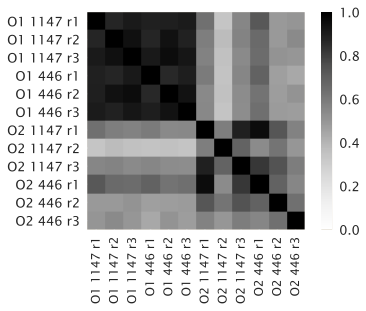

In [46]:
dict_list = [O1_matrix_dict['1147'], O1_matrix_dict['446'], O2_matrix_dict['1147'], O2_matrix_dict['446']]
op_list = ['O1', 'O2']
RBS_list = ['1147', '446']
rep_list = ['r1', 'r2', 'r3']

all_matrices = [mat_dict[rep] for mat_dict in dict_list for rep in rep_list]
all_names = [op + ' ' + RBS + ' ' + rep for op in op_list for RBS in RBS_list for rep in rep_list]

coefs = np.zeros((len(all_matrices), len(all_matrices)))

for i, mat1 in enumerate(all_matrices):
    for j, mat2 in enumerate(all_matrices):
        slope, intercept, r_value, p_value, std_err = linregress(mat1.ravel(), mat2.ravel())
        coefs[i][j] = r_value**2
plt.imshow(coefs, clim=(0,1), zorder=10)
plt.xticks(range(len(all_matrices)), all_names, rotation='vertical')
plt.yticks(range(len(all_matrices)), all_names, rotation='horizontal')
plt.colorbar()

In [47]:
# We can also include the other matrices

# Create lists of RBS and operator names
RBS_name = ['1027', 'RBS1']
repressor_dict = dict(zip(RBS_name, [130, 610]))
operator_name = ['O1', 'O2']

# Make a dictionary for RBS, operator, and matrix files
matrix_dict = {}

for op in operator_name:
    inner_dict = {}
    for RBS in RBS_name:
        inner_dict[RBS] = np.loadtxt('../../data/models/%s%s_fixed_linear_all' % (op, RBS), skiprows=1)
    matrix_dict[op] = inner_dict

In [48]:
dict_list = [O1_matrix_dict['1147'], O1_matrix_dict['446'], O2_matrix_dict['1147'], O2_matrix_dict['446']]
op_list = ['O1', 'O2']
RBS_list = ['1147', '446  ']
repressor_list = [r'$R$ = 30,  ', r'$R$ = 62,  ']
rep_list = ['r1', 'r2', 'r3']

O1_matrices = [mat_dict[rep] for mat_dict in dict_list[0:2] for rep in rep_list]
O1_matrices.append(matrix_dict['O1']['1027'])
O1_matrices.append(matrix_dict['O1']['RBS1'])

O2_matrices = [mat_dict[rep] for mat_dict in dict_list[2:] for rep in rep_list]
O2_matrices.append(matrix_dict['O2']['1027'])
O2_matrices.append(matrix_dict['O2']['RBS1'])

all_matrices = O1_matrices + O2_matrices

O1_names = [R + ' ' + rep for R in repressor_list for rep in rep_list]
O1_names.append(r'$R$ = 130, r1')
O1_names.append(r'$R$ = 610, r1')

O2_names = [R + ' ' + rep for R in repressor_list for rep in rep_list]
O2_names.append(r'$R$ = 130, r1')
O2_names.append(r'$R$ = 610, r1')

all_names = O1_names + O2_names

In [49]:
test_colors = sns.light_palette('#4976b7', as_cmap=True)

# Write function for finding pearson's correlation coefficient

def pearsons(X, Y):
    cov = 0
    for i in range(len(X)):
        cov += (X[i] - np.mean(X)) * (Y[i] - np.mean(Y))/len(X)
    return cov/(np.std(X) * np.std(Y))
    

Text(0.79,0.9,'$\\rho$')

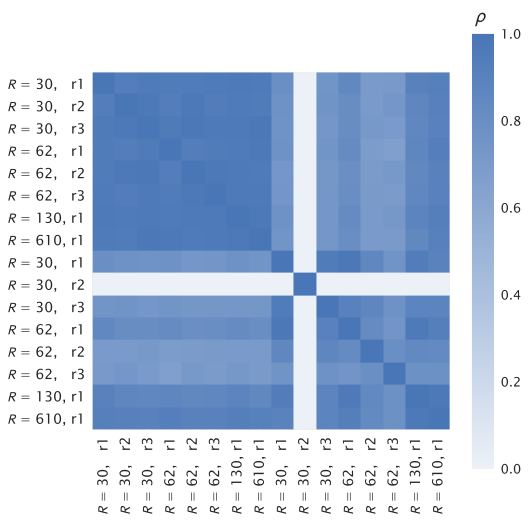

In [50]:
coefs = np.zeros((len(all_matrices), len(all_matrices)))

for i, mat1 in enumerate(all_matrices):
    for j, mat2 in enumerate(all_matrices):
        coefs[i][j] = pearsons(mat1.ravel(), mat2.ravel())
        
plt.figure(figsize=(8, 8))
plt.imshow(coefs, clim=(0,1), zorder=10, cmap=test_colors)
plt.xticks(range(len(all_matrices)), all_names, rotation='vertical', fontsize=14)
plt.yticks(range(len(all_matrices)), all_names, rotation='horizontal', fontsize=14)
plt.colorbar()
plt.figtext(0.79, 0.9, r'$\rho$', fontsize=20)

#plt.savefig('temp_graphics/pearson_coefficients.pdf', bbox_inches='tight')